#### Import Required Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pickle

plt.style.use('fivethirtyeight')

#### Load Data
- load train and test data that were previously cleaned and stored as CSV file format

In [2]:
train_path = "../input/amazon-cleaned-reviews/train.csv"
test_path = "../input/amazon-cleaned-reviews/test.csv"
tokenizer_path = "../input/amazon-cleaned-reviews/tokenizer.pkl"

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.head()

,target,text
0,positive,stuning even for the non gamer this sound trac...
1,positive,the best soundtrack ever to anything i am read...
2,positive,amazing this soundtrack is my favorite music o...
3,positive,excellent soundtrack i truly like this soundtr...
4,positive,remember pull your jaw off the floor after hea...


In [4]:
test.head()

,target,text
0,positive,great cd my lovely pat has one of the great vo...
1,positive,one of the best game music soundtracks for a g...
2,negative,batteries died within a year i bought this cha...
3,positive,works fine but maha energy is better check out...
4,positive,great for the non audiophile reviewed quite a ...


#### Data Splitting
- split data into train set for model training and validation set for model as well as hyperparameter selection

In [12]:
train_text, val_text, train_target, val_target = train_test_split(train['text'], train['target'], test_size=0.15, random_state=42, stratify=train['target'])
test_text, test_target = test['text'], test['target']

print('train input shape {}, train target shape {}'.format(train_text.shape, train_target.shape))
print('val input shape {}, val target shape {}'.format(val_text.shape, val_target.shape))
print('test input shape {}, test target shape {}'.format(test_text.shape, test_target.shape))

#### Word Tokenization
- load fitted tokenizer which is used to map text (sequence of words) into sequence of numbers
- use tokenizer to label encode top 15K - 1 most common words
- words that are unknown to tokenizer and model will be encoded as 1 because 0 is reserved to use for padding the transformed word sequences

In [5]:
MAX_FEATURES = 15e3

tokenizer = pickle.load(open(tokenizer_path, "rb"))

train_tokens = tokenizer.texts_to_sequences(train_text)
val_tokens = tokenizer.texts_to_sequences(val_text)
test_tokens = tokenizer.texts_to_sequences(test_text)

#### Target Transformation
- inverse transform labels from string to integer as model accepts numeric target

In [6]:
reverse_map = {"positive": 1, "negative": 0}

encoded_train = train_target.map(reverse_map)
encoded_val = val_target.map(reverse_map)
encoded_test = test['target'].map(reverse_map)

#### Naive Bayes
- use Multinomial Naive Bayes for text classification 
- in Multinomial Naive Bayes, probability of text input belonging each target class given words in the text is calculated
- among the target classes, class with maximum probability is picked

In [7]:
# plot confusion matrix
def plot_confmat(y_true, predictions):
    labels = ['negative', 'positive']

    conf_mat = confusion_matrix(y_true, predictions, normalize='true')

    plt.figure(figsize=(8,5))
    sns.heatmap(pd.DataFrame(conf_mat, columns=labels, index=labels), annot=True, fmt='.2f')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix of test data')
    plt.show()

- use CountVectorizer to count occurrence of words in sentences
- occurrence of word is later used by Naive Bayes to estimate probability

In [8]:
count_vec = CountVectorizer(analyzer='word', ngram_range=(1, 1))

counts_train = count_vec.fit_transform(train_text)
counts_val = count_vec.transform(val_text)
counts_test = count_vec.transform(test_text)

In [9]:
nb = MultinomialNB()
nb.fit(counts_train, encoded_train)

preds_nb_val = nb.predict(counts_val)
preds_nb_test = nb.predict(counts_test)

#### Naive Bayes Evaluation

In [ ]:
print("ROC AUC score on test set: {0:.4}".format(roc_auc_score(encoded_test, preds_nb_test)))

fpr, tpr, thresholds = roc_curve(encoded_val, preds_nb_val)
optimal_threshold = thresholds[np.argmax(tpr - fpr, axis=0)]
print("Optimal threshold on validation set: {0:.4}".format(optimal_threshold))

In [10]:
print(classification_report(encoded_test, preds_nb_test))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1437
           1       0.87      0.83      0.85      1563

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



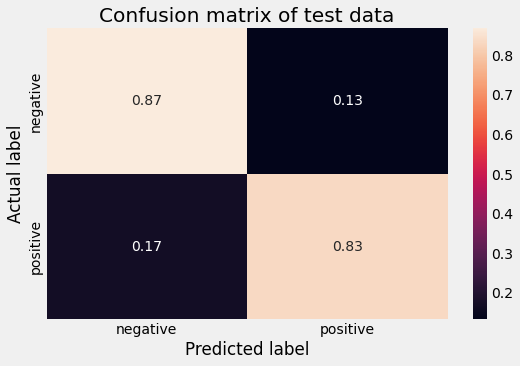

In [11]:
plot_confmat(encoded_test, preds_nb)

- the F1 score from Naive Bayes model for both target classes turned out to be 0.85
- the classification report says that some of positive texts are being predicted as negative
- nevertheless, we should note that Naive Bayes does not take the order of words into account for classifying texts

#### Prepare Dataset
- create tf dataset with batch size 128 to use with model
    - small batch size take long to train
    - large batch size i.e. small no. of steps reduce chance of getting optimal weights sometimes
- from searching, it was recommended to use batch size not larger than 500
- texts will be kept as ragged tensors because ragged tensor length can be flexible which means prediction can be made on text with any length as long as the text fit in memory

In [13]:
train_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(train_text), train_target)).batch(128)
val_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(val_text), val_target)).batch(128)
test_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(test_tokens), encoded_test)).batch(128)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [14]:
# returns a bunch of useful callbacks
def get_callbacks(file_path):
    return [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.3, patience=1, min_lr=0.00001),
        tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss', mode='min', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, min_delta=1e-8, patience=3)
    ]

In [15]:
# plot learning curve
def plot_history(history):
    get_plot_data = lambda metric: [np.arange(len(metric)) + 1, metric]

    plt.figure(figsize=(10,5))

    plt.plot(*get_plot_data(history.history['loss']))
    plt.plot(*get_plot_data(history.history['accuracy']))
    plt.plot(*get_plot_data(history.history['val_loss']))
    plt.plot(*get_plot_data(history.history['val_accuracy']))

    plt.title('Model performance')
    plt.legend(list(history.history.keys())[:-1])
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()

#### Model Training
- use balanced class weight to charge higher for incorrect predictions on minority class which could make model performance nearly even on both classes

In [16]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(train['target']), y=train['target'])
class_weight = dict(enumerate(class_weight))

- model uses Embedding Layer to represent words in texts as aspects
- LSTM is used to help accumulate information from previous parts of sentence while throwing away unimportant information in order to predict sentiment at the end
- LSTMs can use information from words encountered in the sentence long ago to make prediction as opposed to vanilla RNNs

In [17]:
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(int(MAX_FEATURES), 128),
    tf.keras.layers.LSTM(2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
LSTM_history = LSTM_model.fit(train_data, epochs=15, validation_data=val_data, callbacks=get_callbacks('LSTM_model.h5'), class_weight=class_weight)

2022-01-21 05:53:05.727471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


625/625 [==============================] - 120s 187ms/step - loss: 0.4645 - accuracy: 0.8258 - val_loss: 0.3758 - val_accuracy: 0.8554
Epoch 2/15
625/625 [==============================] - 117s 187ms/step - loss: 0.3129 - accuracy: 0.8857 - val_loss: 0.3561 - val_accuracy: 0.8618
Epoch 3/15
625/625 [==============================] - 118s 189ms/step - loss: 0.2731 - accuracy: 0.9005 - val_loss: 0.3052 - val_accuracy: 0.8891
Epoch 4/15
625/625 [==============================] - 117s 187ms/step - loss: 0.2465 - accuracy: 0.9123 - val_loss: 0.2975 - val_accuracy: 0.8924
Epoch 5/15
625/625 [==============================] - 117s 187ms/step - loss: 0.2247 - accuracy: 0.9205 - val_loss: 0.2933 - val_accuracy: 0.8932
Epoch 6/15
625/625 [==============================] - 117s 187ms/step - loss: 0.2074 - accuracy: 0.9273 - val_loss: 0.2900 - val_accuracy: 0.8945
Epoch 7/15
625/625 [==============================] - 118s 188ms/step - loss: 0.1921 - accuracy: 0.9333 - val_loss: 0.2882 - val_accura

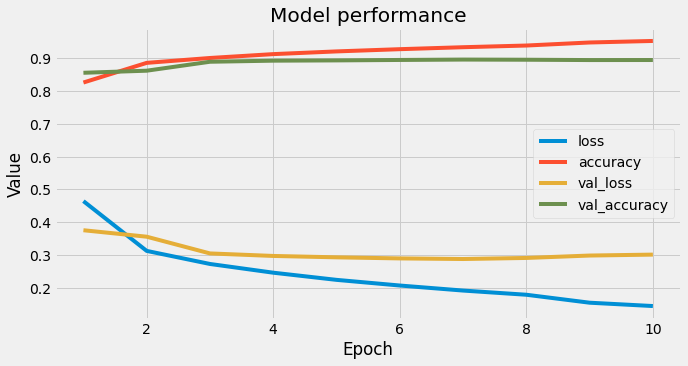

In [19]:
plot_history(LSTM_history)

- the validation loss has decreased by more than 0.06 in 2 nd epoch and began to slowly decrease after that until 8 th epoch
- from epoch 9 onwards, validation accuracy seems to still improve but the loss has not improve though after decreasing learning rate which made the model early stopped

- embedding dimension was increased to 128 from 32 as it helped to better predict sentiment of test data
- increasing the no. of hidden layers in LSTM did not make much improvement in test score
- thus, the no. of LSTM hidden layers is decided to kept small in order to reduce the complexity and prediction time
- originally, adam optimizer was used but the validation loss did not improved much after first few epochs

In [20]:
LSTM_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(int(MAX_FEATURES), 128),
    tf.keras.layers.LSTM(2),
    tf.keras.layers.Dense(128, activation='elu'),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

LSTM_model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
LSTM2_history = LSTM_model2.fit(train_data, epochs=15, validation_data=val_data, callbacks=get_callbacks('LSTM_model2.h5'), class_weight=class_weight)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/lstm_1/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/lstm_1/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/lstm_1/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


625/625 [==============================] - 120s 189ms/step - loss: 0.3803 - accuracy: 0.8348 - val_loss: 0.3000 - val_accuracy: 0.8863
Epoch 2/15
625/625 [==============================] - 117s 188ms/step - loss: 0.2678 - accuracy: 0.8983 - val_loss: 0.3032 - val_accuracy: 0.8817
Epoch 3/15
625/625 [==============================] - 118s 188ms/step - loss: 0.2107 - accuracy: 0.9233 - val_loss: 0.2963 - val_accuracy: 0.8878
Epoch 4/15
625/625 [==============================] - 118s 189ms/step - loss: 0.1979 - accuracy: 0.9287 - val_loss: 0.2810 - val_accuracy: 0.8954
Epoch 5/15
625/625 [==============================] - 119s 190ms/step - loss: 0.1890 - accuracy: 0.9327 - val_loss: 0.2758 - val_accuracy: 0.8986
Epoch 6/15
625/625 [==============================] - 118s 188ms/step - loss: 0.1818 - accuracy: 0.9355 - val_loss: 0.2747 - val_accuracy: 0.8990
Epoch 7/15
625/625 [==============================] - 118s 188ms/step - loss: 0.1753 - accuracy: 0.9379 - val_loss: 0.2730 - val_accura

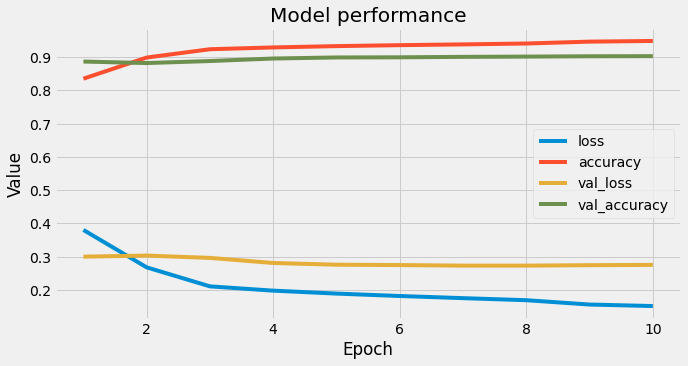

In [22]:
plot_history(LSTM2_history)

- a fully connected layer has been added to see if it could to greaten model prediction ability on test data
- the 4 th epoch seems to provide best validation loss which is lower than the loss of first architecture
- again the validation accuracy enhanced after the best validation loss epoch but it was not the objective

#### Evaluation
- area under curve (ROC AUC score) is used for model evaluation
- probability cut off threshold that gives highest difference between true positives and false positives is determined by points in ROC curve

In [23]:
best_model = tf.keras.models.load_model("./LSTM_model2.h5")

predictions = best_model.predict(tf.ragged.constant(test_tokens))
y_true = encoded_test
val_predictions = best_model.predict(tf.ragged.constant(val_text))
y_true_val = val_target
print("ROC AUC score on test set: {0:.4}".format(roc_auc_score(y_true, predictions)))

fpr, tpr, thresholds = roc_curve(y_true_val, val_predictions)
optimal_threshold = thresholds[np.argmax(tpr-fpr, axis=0)]
print("Optimal threshold on validation set: {0:.4}".format(optimal_threshold))

ROC AUC score on test set: 0.9578
Optimal threshold on validation set: 0.3946


In [24]:
print(classification_report(y_true, predictions >= optimal_threshold))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1437
           1       0.92      0.90      0.91      1563

    accuracy                           0.91      3000
   macro avg       0.90      0.91      0.90      3000
weighted avg       0.91      0.91      0.91      3000



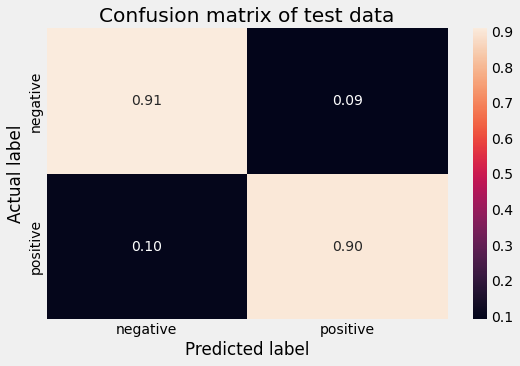

In [25]:
plot_confmat(y_true,  predictions >= optimal_threshold)

- from the classification report, the F1 score of both classes are high and the same which means model is performing well on both classes

#### Prediction
- provide 2 sentences of opposite polarity to model and see if model predict it correctly
- the prediction for each text input is the probability of having positive polarity

In [26]:
best_model.predict(
    tf.ragged.constant(
        tokenizer.texts_to_sequences([
            "it s begin to look a lot like xmas, snow everywhere",
            "so inappropriate i will go some where else that is more suitable"
        ])
    )
)

array([[0.7729906 ],
       [0.03789303]], dtype=float32)